In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, f1_score

from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('../data/credit_card_default_train.csv', index_col = 'Client_ID')

In [3]:
df.head()

Balance_Limit_V1 Gender EDUCATION_STATUS MARITAL_STATUS  \
Client_ID                                                           
A2                      1M      M         Graduate          Other   
A3                      1M      F      High School          Other   
A4                    100K      F      High School         Single   
A5                    200K      F         Graduate         Single   
A6                      1M      F         Graduate          Other   

                    AGE  PAY_JULY  PAY_AUG  PAY_SEP  PAY_OCT  PAY_NOV  ...  \
Client_ID                                                              ...   
A2                31-45        -1       -1       -1       -1       -1  ...   
A3         Less than 30         0       -1       -1       -1       -1  ...   
A4                31-45         4        3        2        2       -2  ...   
A5                31-45         2        0        0        0        0  ...   
A6                31-45         2        2        0        0        0  ...   

           DUE_AMT_OCT  DUE_AMT_NOV  DUE_AMT_DEC  PAID_AMT_JULY  PAID_AMT_AUG  \
Client_ID                                                                       
A2               39418       162772       -13982           3437          6004   
A3               43530        80811       124590         151818         46200   
A4                   0            0            0              0             0   
A5               97309       100353       102740           3855          3890   
A6              435354       445271       453899              0         20790   

           PAID_AMT_SEP  PAID_AMT_OCT  PAID_AMT_NOV  PAID_AMT_DEC  \
Client_ID                                                           
A2                39418        162772             0        538165   
A3                43530         80811           942         33666   
A4                    0             0             0             0   
A5                 3696          4620          4049          3918   
A6                16170         17325         16401         17325   

           NEXT_MONTH_DEFAULT  
Client_ID                      
A2                          0  
A3                          0  
A4                          1  
A5                          1  
A6                          0  

[5 rows x 24 columns]

In [4]:
df.NEXT_MONTH_DEFAULT.value_counts()

0    18670
1     5330
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [5]:
df['balance_limit_multiplier'] = df.Balance_Limit_V1.str[-1].replace({'K':1000, 'M':1000000})
df['balance_limit'] = df.Balance_Limit_V1.str[:-1].astype(float) * df['balance_limit_multiplier']
df['balance_limit'] = df.balance_limit.astype(int)
df.drop(['Balance_Limit_V1', 'balance_limit_multiplier'], inplace=True, axis=1)

# AGE

([<matplotlib.axis.XTick at 0x197c2912b38>,
 <a list of 4 Text xticklabel objects>)

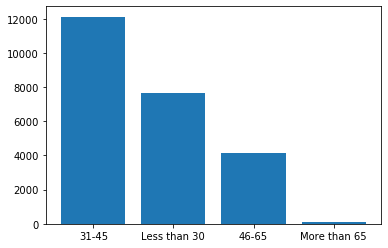

In [6]:
age_values = df.AGE.value_counts()
pos = list(range(age_values.shape[0]))
plt.bar(pos, height=age_values.values)
plt.xticks(pos, age_values.index)

([<matplotlib.axis.XTick at 0x197c28c78d0>,
 <a list of 4 Text xticklabel objects>)

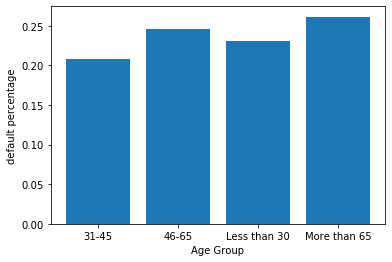

In [7]:
default_perc = df.groupby('AGE').NEXT_MONTH_DEFAULT.mean()
pos = list(range(default_perc.shape[0]))
plt.bar(pos, height=default_perc.values)
plt.xlabel('Age Group')
plt.ylabel('default percentage')
plt.xticks(pos, default_perc.index)

# Gender

([<matplotlib.axis.XTick at 0x197c2963ef0>,
 <a list of 2 Text xticklabel objects>)

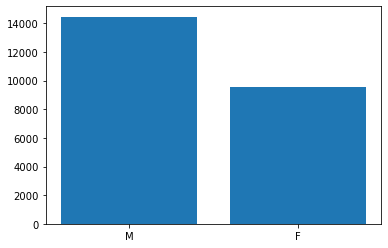

In [8]:
gender_values = df.Gender.value_counts()
pos = list(range(gender_values.shape[0]))
plt.bar(pos, height=gender_values.values)
plt.xticks(pos, gender_values.index)

([<matplotlib.axis.XTick at 0x197c29c7f28>,
 <a list of 2 Text xticklabel objects>)

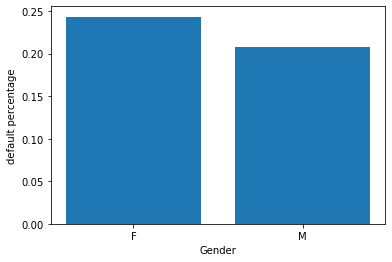

In [9]:
default_perc = df.groupby('Gender').NEXT_MONTH_DEFAULT.mean()
pos = list(range(default_perc.shape[0]))
plt.bar(pos, height=default_perc.values)
plt.xlabel('Gender')
plt.ylabel('default percentage')
plt.xticks(pos, default_perc.index)

# Education Status

([<matplotlib.axis.XTick at 0x197c2a1feb8>,
 <a list of 3 Text xticklabel objects>)

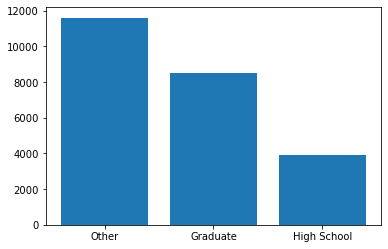

In [10]:
education_values = df.EDUCATION_STATUS.value_counts()
pos = list(range(education_values.shape[0]))
plt.bar(pos, height=education_values.values)
plt.xticks(pos, education_values.index)

([<matplotlib.axis.XTick at 0x197c2a7a320>,
 <a list of 3 Text xticklabel objects>)

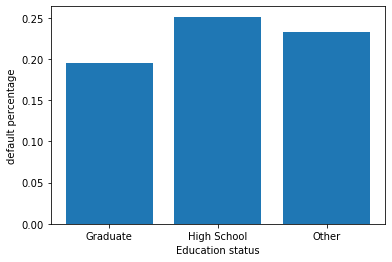

In [11]:
default_perc = df.groupby('EDUCATION_STATUS').NEXT_MONTH_DEFAULT.mean()
pos = list(range(default_perc.shape[0]))
plt.bar(pos, height=default_perc.values)
plt.xlabel('Education status')
plt.ylabel('default percentage')
plt.xticks(pos, default_perc.index)

# Marital Status

([<matplotlib.axis.XTick at 0x197c2ac9f98>,
 <a list of 2 Text xticklabel objects>)

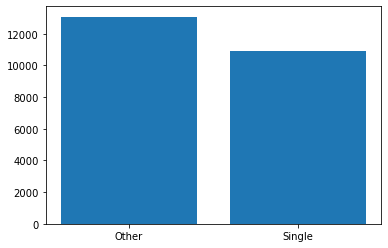

In [12]:
marital_values = df.MARITAL_STATUS.value_counts()
pos = list(range(marital_values.shape[0]))
plt.bar(pos, height=marital_values.values)
plt.xticks(pos, marital_values.index)

([<matplotlib.axis.XTick at 0x197c2b21b38>,
 <a list of 2 Text xticklabel objects>)

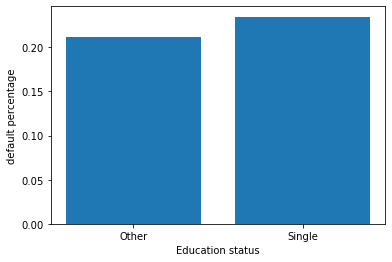

In [13]:
default_perc = df.groupby('MARITAL_STATUS').NEXT_MONTH_DEFAULT.mean()
pos = list(range(default_perc.shape[0]))
plt.bar(pos, height=default_perc.values)
plt.xlabel('Education status')
plt.ylabel('default percentage')
plt.xticks(pos, default_perc.index)

In [14]:
month_list = ['JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
pay_cols = ['PAY_' + m for m in month_list]
paid_cols = ['PAID_AMT_' + m for m in month_list]
due_cols = ['DUE_AMT_' + m for m in month_list]

# Feature Engineering

In [15]:
df['default_count'] = (df[pay_cols] > 0).sum(axis=1)
df['not_default_count'] = (df[pay_cols] <= 0).sum(axis=1)
df['payment_delay_sum'] = df[pay_cols].clip(0).sum(axis=1)
df['payment_advance_sum'] = df[pay_cols].clip(upper=0).sum(axis=1)*-1

In [16]:
default_df = df[df.NEXT_MONTH_DEFAULT == 1]
not_default_df = df[df.NEXT_MONTH_DEFAULT == 0]

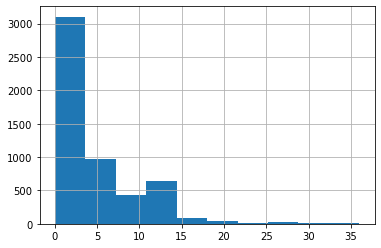

In [17]:
default_df.payment_delay_sum.hist()

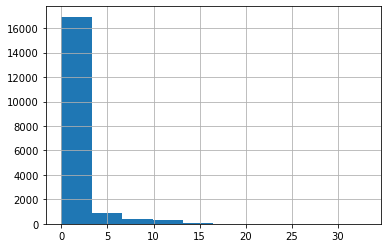

In [18]:
not_default_df.payment_delay_sum.hist()

# Encode categorical

In [19]:
df.columns

Index(['Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE', 'PAY_JULY',
       'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 'PAY_NOV', 'PAY_DEC', 'DUE_AMT_JULY',
       'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT', 'DUE_AMT_NOV',
       'DUE_AMT_DEC', 'PAID_AMT_JULY', 'PAID_AMT_AUG', 'PAID_AMT_SEP',
       'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC', 'NEXT_MONTH_DEFAULT',
       'balance_limit', 'default_count', 'not_default_count',
       'payment_delay_sum', 'payment_advance_sum'],
      dtype='object')

In [20]:
cat_cols = ['Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE']

In [21]:
X = df.drop('NEXT_MONTH_DEFAULT', axis=1)
y = df['NEXT_MONTH_DEFAULT']

In [22]:
onehot = ce.OneHotEncoder(cols=cat_cols, use_cat_names=True)

In [23]:
onehot.fit(X)

OneHotEncoder(cols=['Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', return_df=True, use_cat_names=True,
              verbose=0)

In [24]:
X = onehot.transform(X)

# Train test split

In [25]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.7, random_state=42)

# Model Definition

## Random Forest

In [34]:
model = RandomForestClassifier(n_estimators=2000, n_jobs=-1,  max_depth=4, max_features=10, random_state=42)

## XGBoost

In [108]:
# neg_count = (train_y == 0).sum()
# pos_count = (train_y == 1).sum()
# model = XGBClassifier(n_estimators=1000, max_depth=6, 
#                       n_jobs=-1, verbose=1, learning_rate=0.01, subsample=1, colsample_bytree=1)

# Model training and evaluation

In [98]:
confusion_matrix(test_y, pred_y)

array([[5365,  234],
       [1021,  580]], dtype=int64)

In [35]:
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
print(classification_report(test_y, pred_y))
print(f1_score(test_y, pred_y, average='micro') * 100)

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      5599
           1       0.71      0.36      0.48      1601

    accuracy                           0.83      7200
   macro avg       0.78      0.66      0.69      7200
weighted avg       0.81      0.83      0.80      7200

82.56944444444444


In [96]:
pred_train_y = model.predict(train_X)
print(classification_report(train_y, pred_train_y))
print(f1_score(train_y, pred_train_y, average='micro') * 100)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89     13071
           1       0.69      0.36      0.48      3729

    accuracy                           0.82     16800
   macro avg       0.77      0.66      0.68     16800
weighted avg       0.81      0.82      0.80     16800

82.25


In [97]:
print(accuracy_score(test_y, pred_y))

0.8256944444444444


In [47]:
pd.Series(model.feature_importances_, index=train_X.columns).sort_values(ascending=False)

PAY_JULY                        0.325720
payment_delay_sum               0.212629
default_count                   0.126763
not_default_count               0.120064
PAY_AUG                         0.061145
PAY_SEP                         0.022756
PAY_OCT                         0.015219
PAID_AMT_JULY                   0.014964
DUE_AMT_JULY                    0.013268
PAY_DEC                         0.011083
PAY_NOV                         0.010694
PAID_AMT_AUG                    0.010402
PAID_AMT_SEP                    0.008584
PAID_AMT_OCT                    0.008005
PAID_AMT_NOV                    0.006183
balance_limit                   0.005771
DUE_AMT_NOV                     0.005550
DUE_AMT_AUG                     0.004679
DUE_AMT_SEP                     0.003427
DUE_AMT_OCT                     0.003098
payment_advance_sum             0.002931
DUE_AMT_DEC                     0.002800
PAID_AMT_DEC                    0.002379
EDUCATION_STATUS_Graduate       0.000562
Gender_M        

# Predictions on test set

In [36]:
df_test = pd.read_csv('../data/credit_card_default_test.csv', index_col='Client_ID')

In [37]:
df_test['balance_limit_multiplier'] = df_test.Balance_Limit_V1.str[-1].replace({'K':1000, 'M':1000000})
df_test['balance_limit'] = df_test.Balance_Limit_V1.str[:-1].astype(float) * df_test['balance_limit_multiplier']
df_test['balance_limit'] = df_test.balance_limit.astype(int)
df_test.drop(['Balance_Limit_V1', 'balance_limit_multiplier'], inplace=True, axis=1)

In [38]:
df_test['default_count'] = (df_test[pay_cols] > 0).sum(axis=1)
df_test['not_default_count'] = (df_test[pay_cols] <= 0).sum(axis=1)
df_test['payment_delay_sum'] = df_test[pay_cols].clip(0).sum(axis=1)
df_test['payment_advance_sum'] = df_test[pay_cols].clip(upper=0).sum(axis=1)*-1

In [39]:
X = df_test

In [40]:
X = onehot.transform(X)

In [41]:
pred_y = model.predict(X)

In [42]:
output_df = pd.Series(pred_y, index=df_test.index).to_frame()

In [43]:
output_df.columns = ['NEXT_MONTH_DEFAULT']

In [44]:
output_df.NEXT_MONTH_DEFAULT.value_counts()

0    5335
1     665
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [46]:
output_df.head()

NEXT_MONTH_DEFAULT
Client_ID                    
A20170                      0
A16887                      0
A3430                       0
A3696                       0
A20474                      0

In [45]:
output_df.to_csv('../output/submission.csv')